<a href="https://colab.research.google.com/github/zyf2021/DL_materials/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22part_1_linear_regression_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1aS4vX-ucDKBmZmZMrBwgjl_DvLAadX2C" width=900/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h1 style="text-align: center;"><b>Семинар. Линейная регрессия</b></h1>

В этом ноутбуке мы реализуем алгоритм линейной регрессии и протестируем его на искусственных данных. Для удобства данные методы будем реализовывать в виде классов в Python наподобие соотвествующих классов из sklearn.

In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge

# 1. Линейная регрессия

Линейные методы предполагают, что между признаками объекта (features) и целевой переменной (target/label) существует линейная зависимость, то есть
$$y = w_1 x_1 + w_2 x_2 + ... + w_n x_n + b, $$
где
* $y$ --- целевая переменная (то, что мы хотим предсказать),
* $x_1, \ldots, x_n$ --- признаки объекта $\mathbf{x}$,
* $w_i$ --- вес $i$-го признака, $b$ --- bias (смещение, свободный член).

Часто предполагают, что объект $\mathbf{x}$ содержит в себе фиктивный признак равный 1 для представления свободного члена $b$. В этом случае формула принимает простой вид:
$$y = \langle \mathbf{w}, \mathbf{x} \rangle,$$
где $\langle \cdot, \cdot \rangle$ -- скалярное произведение векторов $\mathbf{w}$, $\mathbf{x} \in \mathbb{R}^n$.

В многомерном случае формулу линейной регрессии можно переписать следующим образом:
$$ \mathbf{y} = X\mathbf{w}, $$
где
* $\mathbf{y}$ -- столбец размера $\ell$ (количество объектов),
* $X$ --- матрица признаков размера $\ell \times n$ (каждая строка матрицы является вектором признаков объекта),
* $\mathbf{w}$ -- вектор весов размера $n$.

**Лосс:**
$$
\begin{aligned}
L(\mathbf{w}) &= \frac{1}{\ell}||\mathbf{y}_{pred} - \mathbf{y}||^2_2 =\\
&= \frac{1}{\ell}||X\mathbf{w} - \mathbf{y}||^2_2 = \frac{1}{\ell}\sum_{i=1}^{\ell}\left(\sum_{j=1}^{n} x_{ij}w_j - y_i\right)^2
\end{aligned}
$$

### 1.1 Аналитическое решение

Минимизация ошибки по методу наименьших квадратов дает решение: $$ \mathbf{w} = (X^TX)^{-1}X^T \mathbf{y} $$

Реализуем класс линейной регрессии с помощью этой формулы.

In [2]:
class MyLinearRegression:
    def __init__(self):
        self.w = None

    def fit(self, X, y):
        # Принимает на вход X, y и вычисляет веса по данной выборке
        # Не забудьте про фиктивный признак равный 1
        X = np.array(X)
        y = np.array(y)
        assert len(y.shape) == 1 and len(X.shape) == 2
        assert X.shape[0] == y.shape[0]

        y = y[:, np.newaxis] # ell, 1
        l, n = X.shape

        X_train = np.hstack((X, np.ones((l, 1))))

        self.w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y

        return self

    def predict(self, X):
        # Принимает на вход X и возвращает ответы модели
        # Не забудьте про фиктивный признак равный 1
        l, n = X.shape

        X_train = np.hstack((X, np.ones((l, 1))))

        y_pred = X_train @ self.w

        return y_pred

    def get_weights(self):
        return self.w.copy()
        # copy тут используется неспроста. Если copy не использовать, то get_weights()
        # выдаст ссылку на объект, а, значит, модифицируя результат применения функции
        # get_weights(), вы модифицируете и веса self.w. Если вы хотите модифицировать веса,
        # (например, в fit), используйте self.w


#### Тестирование
Сначала сгенерируем искусственные данные для теста моделей

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
def linear_expression(x):
    return 5 * x + 6

In [5]:
# по признакам сгенерируем значения таргетов с некоторым шумом
objects_num = 50
X = np.linspace(-5, 5, objects_num)
y = linear_expression(X) + np.random.randn(objects_num) * 5

# выделим половину объектов на тест
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

Нанесем точки выборки и зависимость на график для наглядности

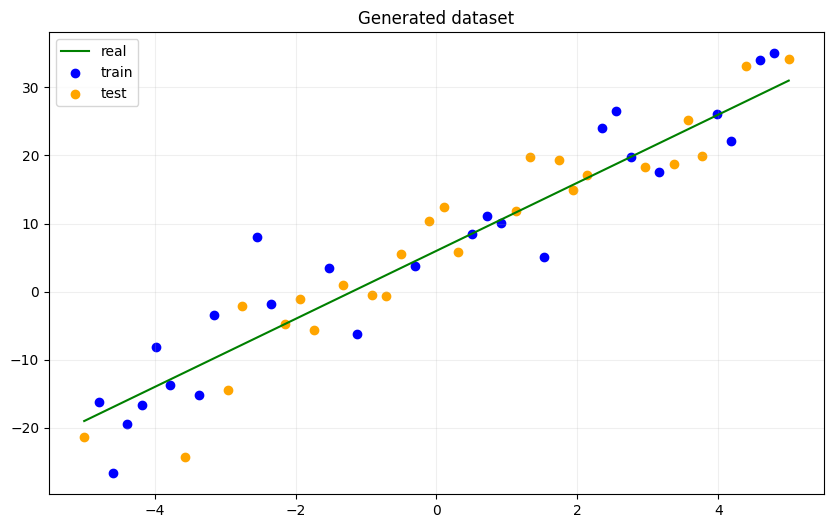

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(X, linear_expression(X), label='real', c='g')
plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title("Generated dataset")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

Обучим модель на трейне и предскажем результаты на тесте

In [7]:
regressor = MyLinearRegression()

regressor.fit(X_train[:, np.newaxis], y_train) # используется для изменения размерности массива, добавляя новую ось.

predictions = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()
w

array([[5.11070431],
       [6.74888144]])

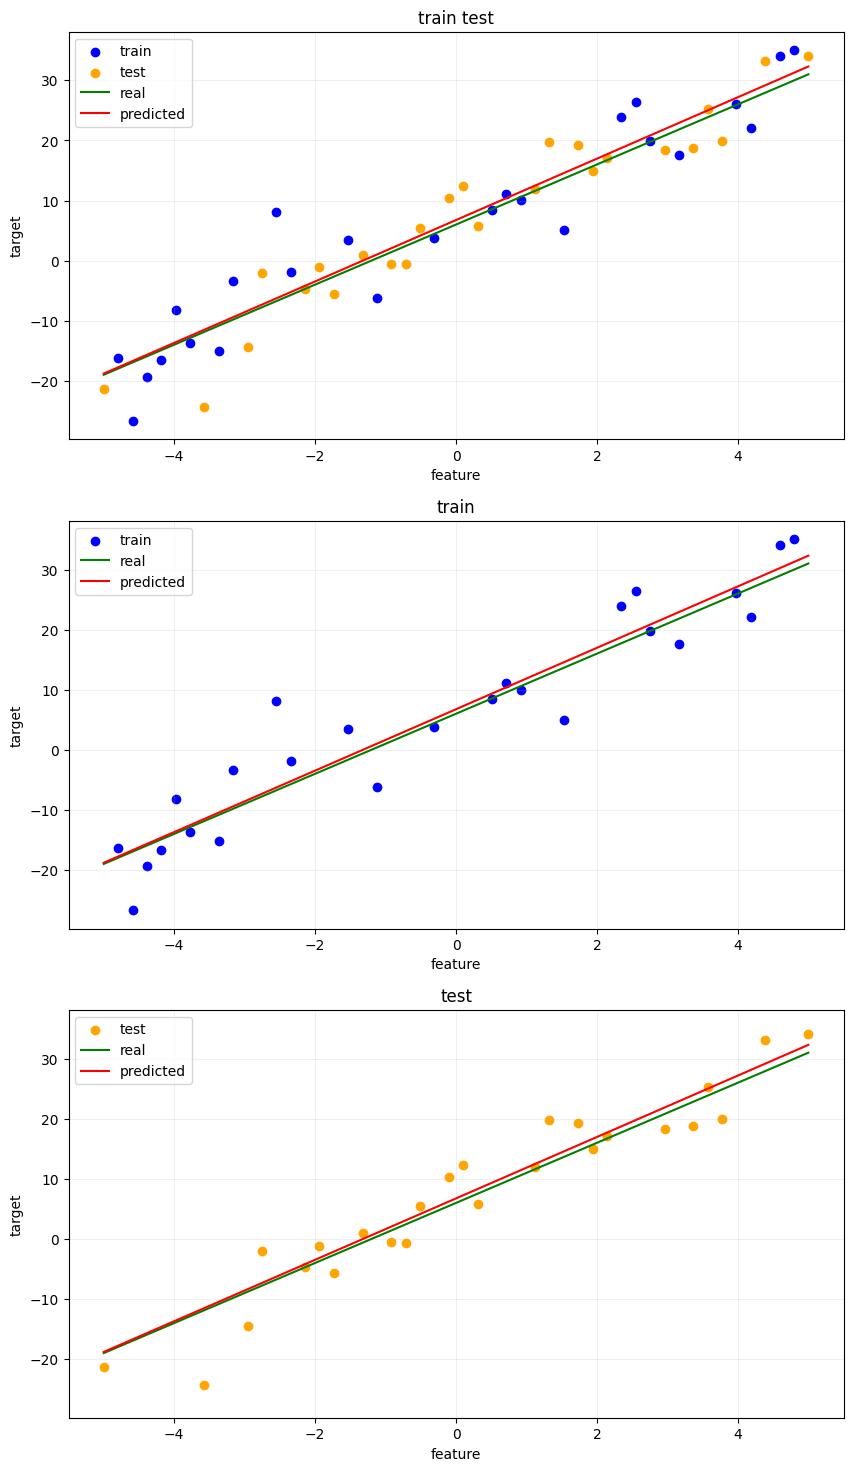

In [8]:
plt.figure(figsize=(10, 18))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(3, 1, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')

    plt.plot(X, linear_expression(X), label='real', c='g')
    plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

Сравним с реализацией из sklearn

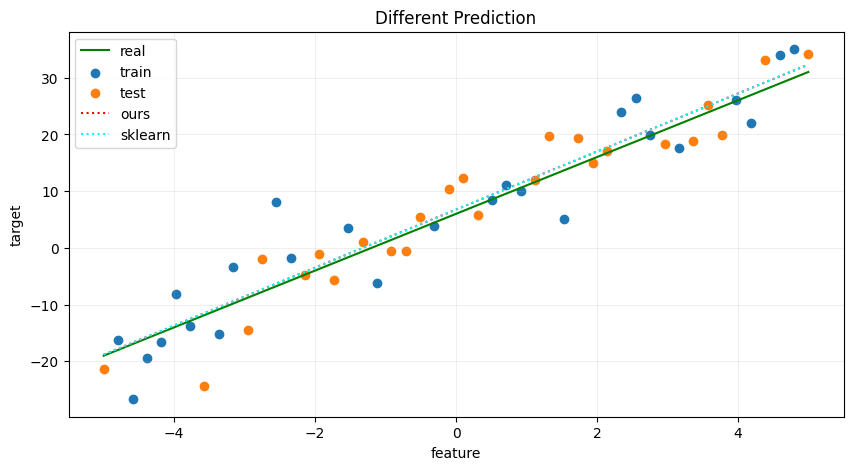

In [9]:
sk_reg = LinearRegression().fit(X_train[:, np.newaxis], y_train)

plt.figure(figsize=(10, 5))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='ours', c='r', linestyle=':')
plt.plot(X, sk_reg.predict(X[:, np.newaxis]), label='sklearn', c='cyan', linestyle=':')

plt.title("Different Prediction")
plt.ylabel('target')
plt.xlabel('feature')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [ ]:
sk_reg.coef_, sk_reg.intercept_

(array([5.24827475]), 6.435412167537866)

#### Результаты

In [10]:
from sklearn.metrics import mean_squared_error

train_predictions = regressor.predict(X_train[:, np.newaxis])
test_predictions = regressor.predict(X_test[:, np.newaxis])

print('Train MSE: ', mean_squared_error(y_train, train_predictions))
print('Test MSE: ', mean_squared_error(y_test, test_predictions))

Train MSE:  30.509017848062268
Test MSE:  19.022652851626987


### 1.2. Градиентная оптимизация

Для линейной регрессии решение задачи оптимизации можно выписать в явном виде.Но такое случается не для всех задач (это мы еще увидим позже). По этим причинам, мы воспользуемся методом градиентного спуска для оптимизации эмпирического риска.

Градиентый спуск заключается в следующих шагах:
1. Расчёт $\displaystyle\frac{\partial{L}}{\partial{\mathbf{w}}}$ -- градиента функции потерь $L(\mathbf{w})$ -- от значения параметров модели (весов $\mathbf{w}$);
2. Шаг спуска -- изменение весов $\mathbf{w}$ в сторону антиградиента с некоторым коэффициентом $\alpha$ (он же learning rate):
$$\mathbf{w} := \mathbf{w} - \alpha\frac{\partial{L}}{\partial{\mathbf{w}}};$$
3. Повторение п.1 и п.2 пока не наблюдается сходимость (изменения ошибки малы или отсутсвуют).



**Цель:** Реализуем новые классы линейной регрессии, в которой оптимизация проводится методами градиентного спуска.

**Предполагаемая зависимость:** $\mathbf{y} = X\mathbf{w}$, где $\mathbf{y} \in \mathbb{R}^{\ell\times 1}, X \in \mathbb{R}^{\ell\times n}, \mathbf{w} \in \mathbb{R}^{n\times 1}$


**Минимизируемая функция:**
$$
L(\mathbf{w}) = \frac{1}{\ell} ||\mathbf{y}_{pred} - \mathbf{y}||^2 = \frac{1}{\ell}||X\mathbf{w} - \mathbf{y}||^2 = \frac{1}{\ell}(X\mathbf{w} - \mathbf{y})^T(X\mathbf{w} - \mathbf{y}) = \frac{1}{\ell}(\mathbf{w}^TX^TX\mathbf{w} - 2\mathbf{y}^TX\mathbf{w} + \mathbf{y}^T\mathbf{y})
$$

**Градиент относительно $\mathbf{w}$:**
$$
\frac{\partial{L}}{\partial{\mathbf{w}}} = \frac{2}{\ell}(X^TX\mathbf{w} - X^T\mathbf{y}) = \frac{2}{\ell}X^T(\mathbf{y}_{pred} - \mathbf{y}) \,\, \in \mathbb{R}^{n \times 1}
$$

In [11]:
class MyGradientLinearRegression(MyLinearRegression):
    def __init__(self, **kwargs):
        super().__init__(**kwargs) # передает именные параметры родительскому конструктору

    def fit(self, X, y, lr=0.01, max_iter=100):
        # Принимает на вход X, y и вычисляет веса по данной выборке
        # Не забудьте про фиктивный признак равный 1
        X = np.array(X)
        y = np.array(y)
        assert len(y.shape) == 1 and len(X.shape) == 2
        assert X.shape[0] == y.shape[0]

        y = y[:, np.newaxis]
        l, n = X.shape

        # Добавляем признак из единиц
        X_train = np.hstack((X, np.ones((l, 1))))  # [l, n+1]

        self.w = np.random.randn(n + 1, 1)

        self.losses = []

        for iter_num in range(max_iter):
            y_pred = self.predict(X)
            self.losses.append(mean_squared_error(y, y_pred))

            grad = self._calc_gradient(X_train, y, y_pred)

            assert grad.shape == self.w.shape, \
            f"gradient shape {grad.shape} is not equal weight shape {self.w.shape}"

            self.w -= lr * grad

        return self

    def _calc_gradient(self, X, y, y_pred):
        grad = (2. / X.shape[0]) * (X.T @ (y_pred - y))

        return grad

    def get_losses(self):
        return self.losses

#### Тестирование

Посчитаем предсказания на сгенерированном датасете

In [12]:
regressor = MyGradientLinearRegression()

l = regressor.fit(X_train[:, np.newaxis], y_train, max_iter=100).get_losses()

predictions = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()

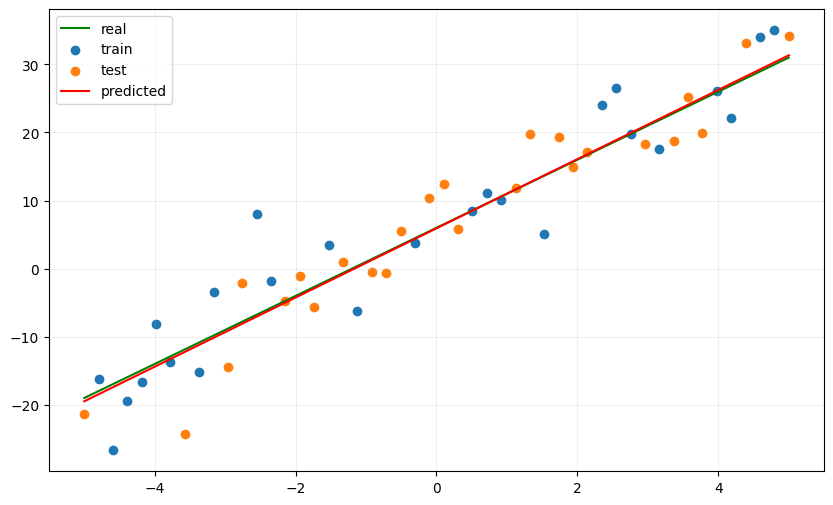

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

Построим таккже график лосса во время обучения

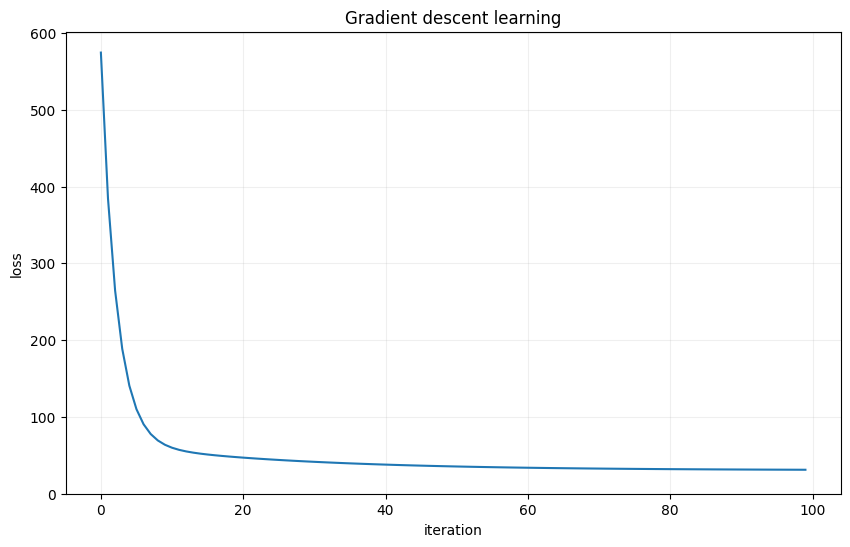

In [14]:
plt.figure(figsize=(10, 6))

plt.plot(l)

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.ylim(bottom=0)
plt.grid(alpha=0.2)

plt.show()

### 1.3 Стохастический градиентный спуск

Считать градиент по всей обучающей выборке на каждом шаге градиентного спуска слишком дорого. Стохастический градиентный спуск (SGD) -- это улучшение обычного градиентного спуска, которое позволяет решить эту проблему.

На каждой итерации градиентного спуска будем считать градиент функции потерь не по всей выборке, а лишь по подмножеству выборки фиксированного размера $k$ (такое подмножество называется **батч**). Существует несколько способов реализовать SGD:

1. На каждом шаге спуска выбирать случайный батч.
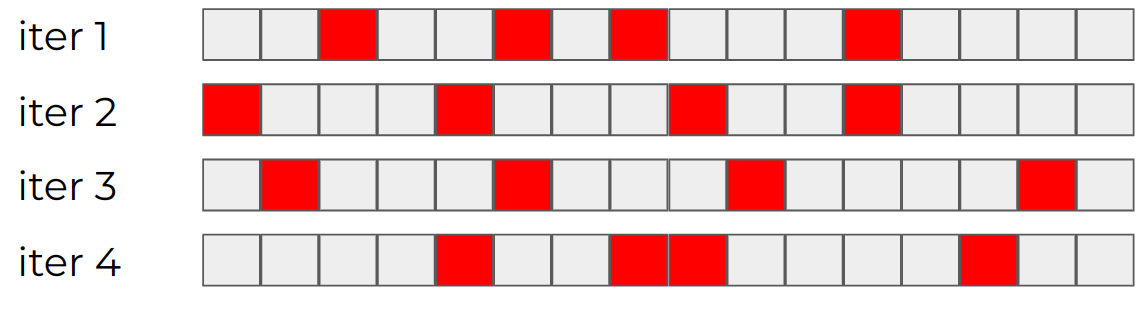
2. Разделить обучение на эпохи, на каждой эпохе перемешивать выборку и проходиться батчами по всем элементам выборки.
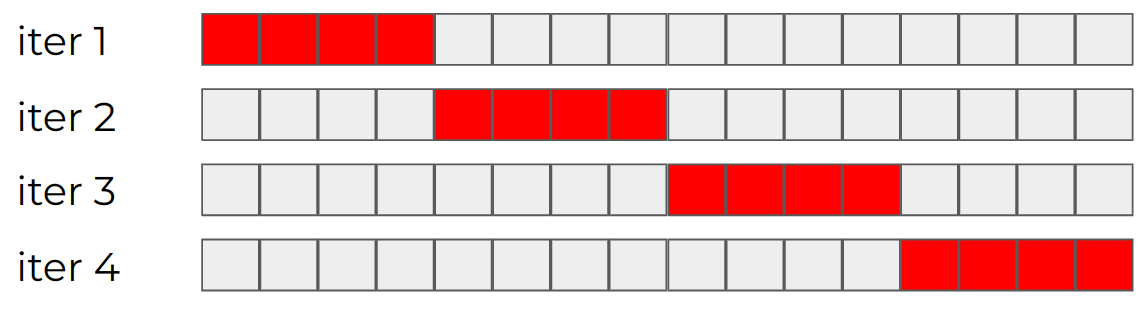



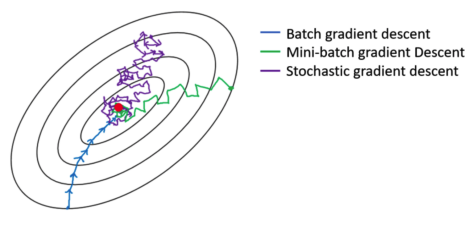

Второй способ вам необходимо будет использовать в домашнем задании. Для этого вам предстоит разобраться в генераторах в Python. Статья, которая вам в этом поможет: [тык](https://pythonru.com/uroki/30-generatory-dlja-nachinajushhih).

**Кратко** (благодарим Ольгу Липину, нашу слушательницу, которая написала этот комментарий к домашнему заданию):




> `yield` - это аналог `return`. Только `return` сразу выкидывает нас из функции, возвращая значение. А `yield` возвращает значение, и функция переходит в режим ожидания. И если мы вызовем её ещё раз, она продолжит работу с того же места, на котором остановилась.
>
> С помощью `yield` пишут генераторы. Конкретно здесь от нас хотят, чтоб мы написали генератор батчей. `yield` на каждом шаге возвращает `(batch_x, batch_y)`. И мы пишем цикл, который считает `batch_x`, `batch_y` и делает `yield batch_x, batch_y`. Таким образом, когда мы проходимся по объекту-генератору, функция на каждом шаге:
>
> 1. Возвращает нам батч.
> 2. Останавливается, запоминая предыдущее состояние.
> 3. На следующем шаге с текущего состояния, которое она помнит, возвращает новый батч

Если сейчас этот текст непонятен, ничего страшного. Вернитесь к нему, когда будете решать домашнее задание.


Мы будем пользоваться первым способом, потому что его проще реализовать. Добавим к нашему градиентному спуску сэмплирование батча, по которому будем считать градиент


In [19]:
class MySGDLinearRegression(MyGradientLinearRegression):
    def __init__(self, n_sample=10, **kwargs):
        super().__init__(**kwargs) # передает именные параметры родительскому конструктору
        self.w = None
        self.n_sample = n_sample

    def _calc_gradient(self, X, y, y_pred):
        # Главное отличие в SGD -- это использование подвыборки для шага оптимизации
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)
        # grad = (2. / X.shape[0]) * (X.T @ (y_pred - y))
        grad = 2 / self.n_sample * X[inds].T @ (y_pred[inds] - y[inds])

        return grad

#### Тестирование

Проведем аналогичный расчет на сгенерированном датасете

In [20]:
regressor = MySGDLinearRegression()

l = regressor.fit(X_train[:, np.newaxis], y_train, max_iter=100).get_losses()

predictions = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()

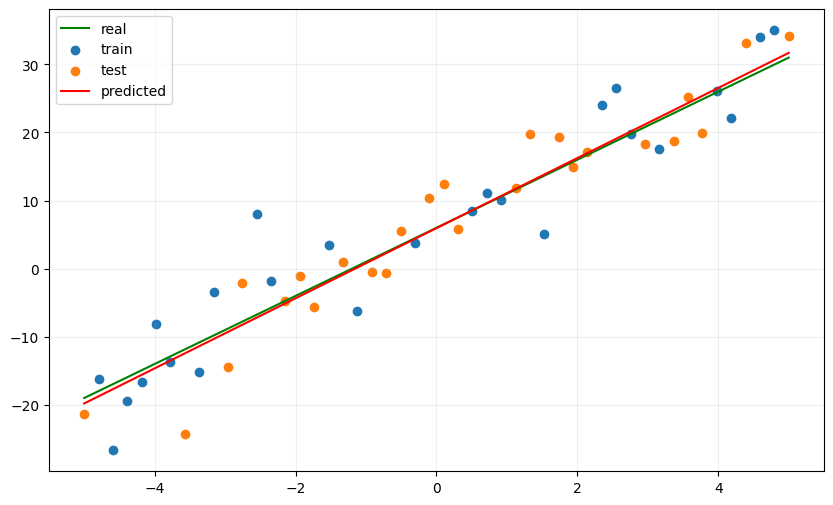

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

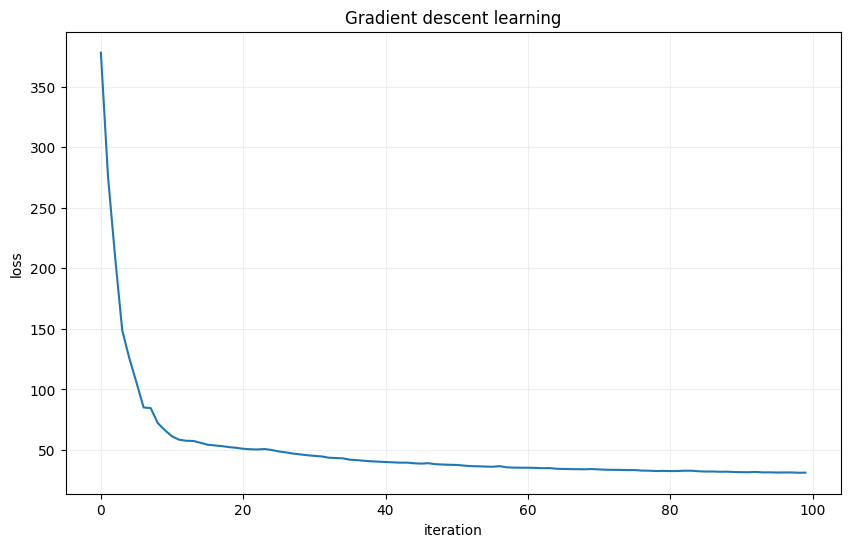

In [18]:
plt.figure(figsize=(10, 6))

plt.plot(l)

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid(alpha=0.2)
plt.show()

Протестируем, меняя количество элементов для расчета градиента

In [23]:
n_samples = [1, 4, 10, 16]

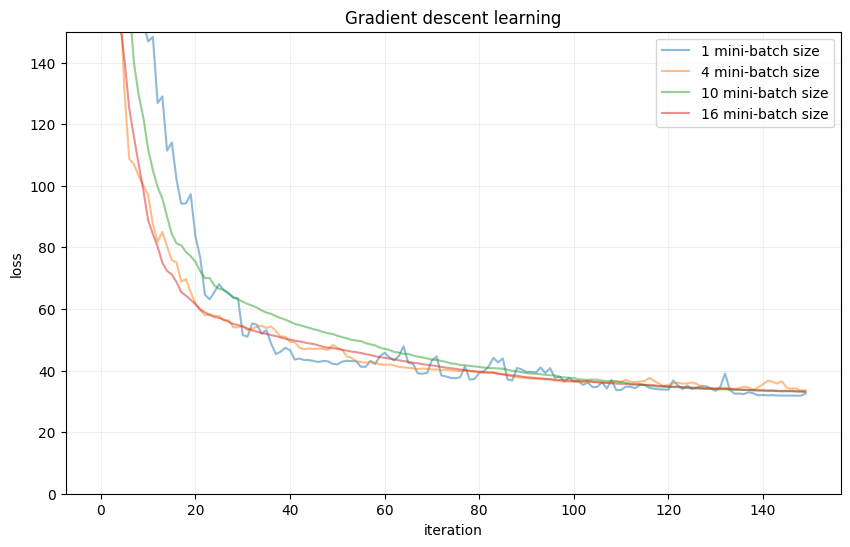

In [24]:
plt.figure(figsize=(10, 6))

for ns in n_samples:
    l = MySGDLinearRegression(n_sample=ns).fit(
        X_train[:, np.newaxis],
        y_train,
        lr=5e-3,
        max_iter=150,
    ).get_losses()
    plt.plot(l, alpha=0.5, label=f'{ns} mini-batch size')

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')

plt.legend()
plt.ylim((0, 150))
plt.grid(alpha=0.2)
plt.show()

Как видно по графикам, размер подвыборки влияет на стабильность сходимости (чем меньше, тем больше и резче изменения весов).
При этом количество итераций для минимизации примерно одинаково.

SGD также обычно улучшают адаптивным уменьшением величины шага (подробнее в курсах про методы оптимизаций)
